In [46]:
# (16-726): Project 1 starter Python code
# credit to https://inst.eecs.berkeley.edu/~cs194-26/fa18/hw/proj1/data/colorize_skel.py
# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform
import os
from functools import partial


In [18]:
skio.use_plugin('matplotlib', 'imshow')


# The following plug-ins are available:

# ========== ==============================================================
# Plugin     Description
# ---------- --------------------------------------------------------------
# qt         Fast image display using the Qt library. Deprecated since
#            0.18. Will be removed in 0.20.
# imread     Image reading and writing via imread
# gdal       Image reading via the GDAL Library (www.gdal.org)
# simpleitk  Image reading and writing via SimpleITK
# gtk        Fast image display using the GTK library
# pil        Image reading via the Python Imaging Library
# fits       FITS image reading via PyFITS
# matplotlib Display or save images using Matplotlib
# tifffile   Load and save TIFF and TIFF-based images using tifffile.py
# imageio    Image reading via the ImageIO Library
# ========== ==============================================================()

In [53]:
def show(im):
    skio.imshow(im)
    skio.show()

In [37]:

# name of the input file
imname = 'data/emir.tif'

# read in the image
im = skio.imread(imname)

def get_channels(im):
    # convert to double (might want to do this later on to save memory)
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int64)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    return r,g,b
r,g,b = get_channels(im)


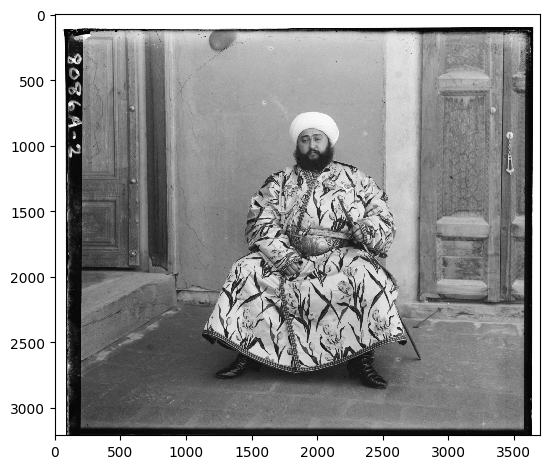

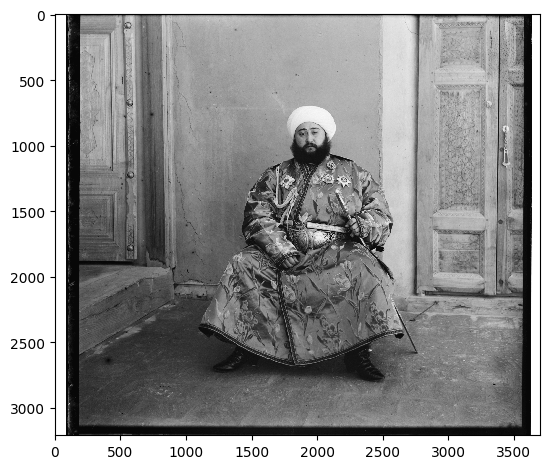

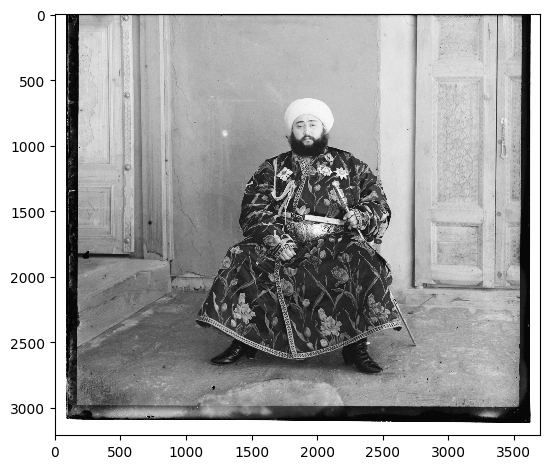

In [38]:
for channel in (b,g,r):
    skio.imshow(channel)
    skio.show()

In [84]:
# aligning, stacking, post_processing algorithms
def dumb_stack(r,g,b):
    return np.dstack([r, g, b]), (0,0), (0,0)
def ssd_brute_force_stack(r,g,b):
    """
    Align channels by minimizing sum of squared differences.
    L2 norm also known as the Sum of Squared Differences (SSD) distance 
    which is simply sum(sum((image1-image2).^2)) 
    where the sum is taken over the pixel values.

    Args:
        r (np.ndarray): channel that is not aligned with the other two
        g (np.ndarray): channel that is not aligned with the other two
        b (np.ndarray): channel that is not aligned with the other two
    """
    def preprocess(channel):
        h, w = channel.shape
        channel = sk.transform.rescale(channel, 1/4) # scale down to reduce search space
        return channel

    def align(c1, c2):
        """align by ssd two channels"""
        scaled1 = preprocess(c1)
        scaled2 = preprocess(c2)
        min_ssd = np.Inf
        argmin_dx = 0
        argmin_dy = 0
        for dx in range(-10,10):
            for dy in range(-5,40):
                shifted = np.roll(scaled1, dx, axis=1)
                shifted = np.roll(shifted, dy, axis=0)
                ssd = np.sum(np.power(scaled2-shifted, 2))
                if ssd < min_ssd:
                    min_ssd = ssd
                    argmin_dx = dx
                    argmin_dy = dy
        c1 = np.roll(c1, argmin_dy*4, 0)
        c1 = np.roll(c1, argmin_dx*4, 1)
        return c1, (argmin_dy*4, argmin_dx*4)
    ag, g_shift = align(g, b)
    ar, r_shift = align(r, b)
    # show(np.dstack([ar, ag, b]))
    # show(dumb_stack(r,g,b))
    return np.dstack([ar, ag, b]), r_shift, g_shift

def ncc_brute_force_stack(r,g,b, crop=False):
    """
    normalized cross-correlation (NCC), which is simply a dot product 
    between two normalized vectors: (image1./||image1|| and image2./||image2||).

    Args:
        r (np.ndarray): channel that is not aligned with the other two
        g (np.ndarray): channel that is not aligned with the other two
        b (np.ndarray): channel that is not aligned with the other two
    """
    def preprocess(channel):
        h, w = channel.shape
        if crop:
            channel = channel[h//10:h-h//10, w//10:w-w//10] # only keep center 80%
        channel = sk.transform.rescale(channel, 1/4) # scale down to reduce search space
        channel = (channel-channel.mean())/channel.std() # normalizem
        return channel

    def align(c1, c2):
        """align by ssd two channels"""
        scaled1 = preprocess(c1)
        scaled2 = preprocess(c2)
        min_ncc = np.Inf
        argmin_dx = 0
        argmin_dy = 0
        for dx in range(-10,10):
            for dy in range(-5,40):
                shifted = np.roll(scaled1, dx, axis=1)
                shifted = np.roll(shifted, dy, axis=0)
                ncc = np.sum(np.power(scaled2-shifted, 2))
                if ncc < min_ncc:
                    min_ncc = ncc
                    argmin_dx = dx
                    argmin_dy = dy
        c1 = np.roll(c1, argmin_dy*4, 0)
        c1 = np.roll(c1, argmin_dx*4, 1)
        return c1, (argmin_dy*4, argmin_dx*4)
    ag, g_shift = align(g, b)
    ar, r_shift = align(r, b)
    return np.dstack([ar, ag, b]), r_shift, g_shift
# show(ncc_brute_force_stack(r,g,b))

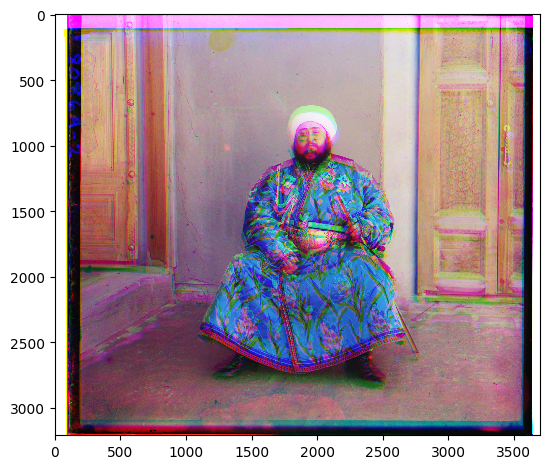

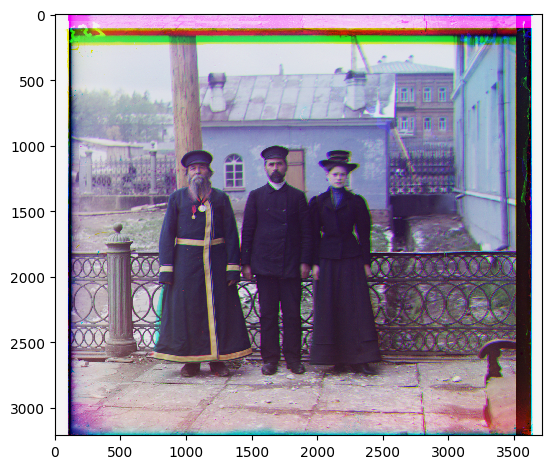

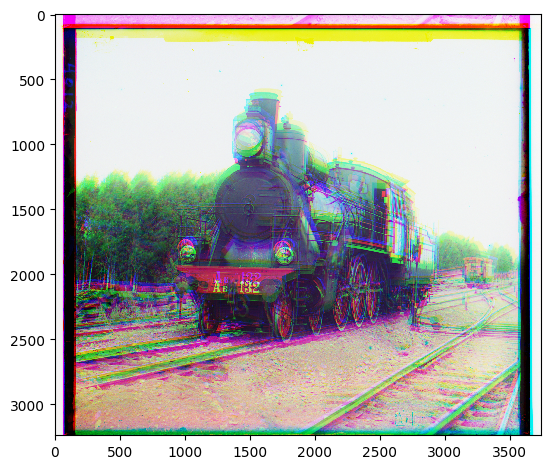

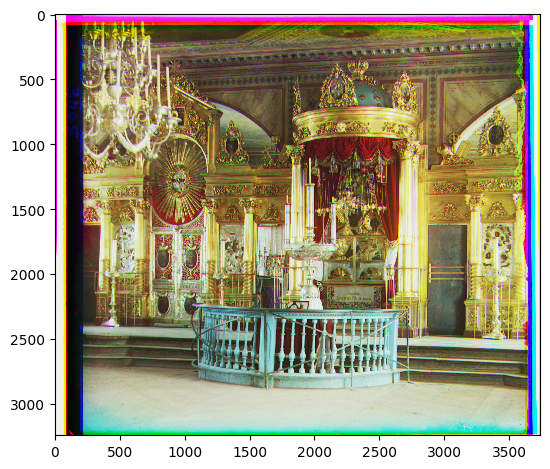

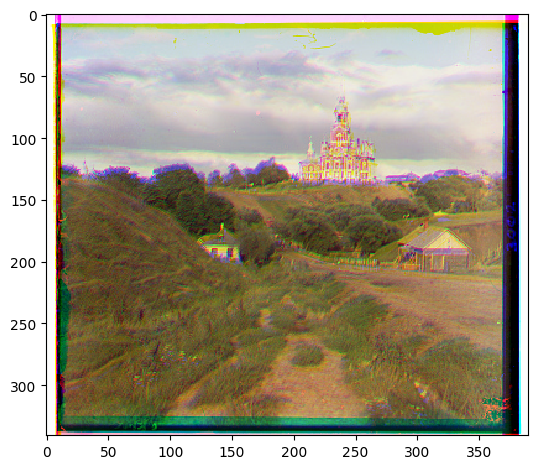

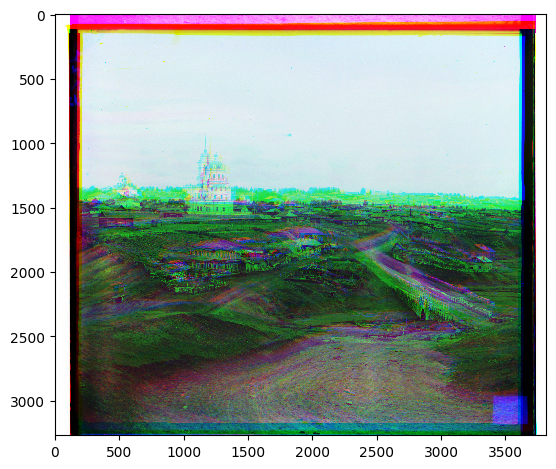

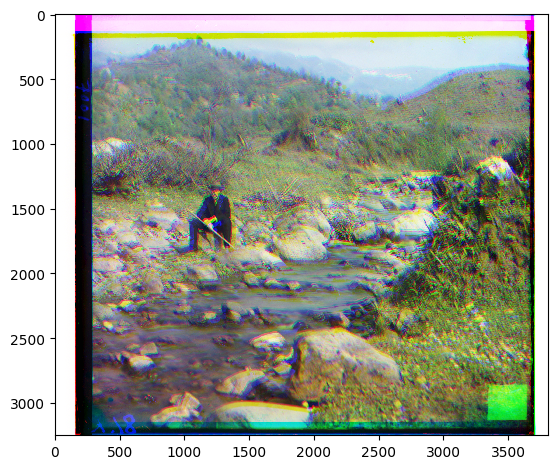

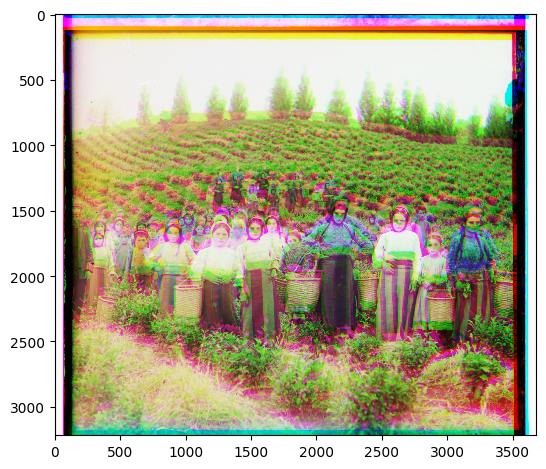

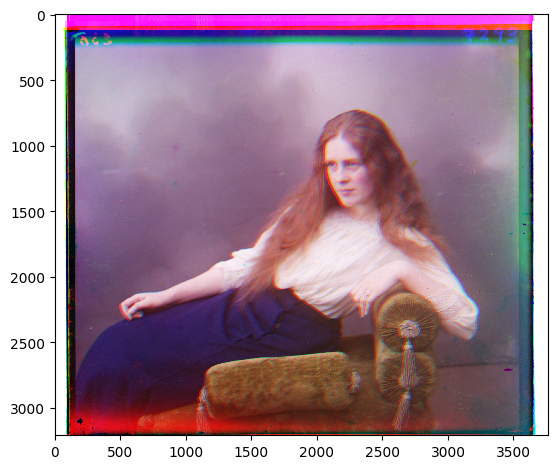

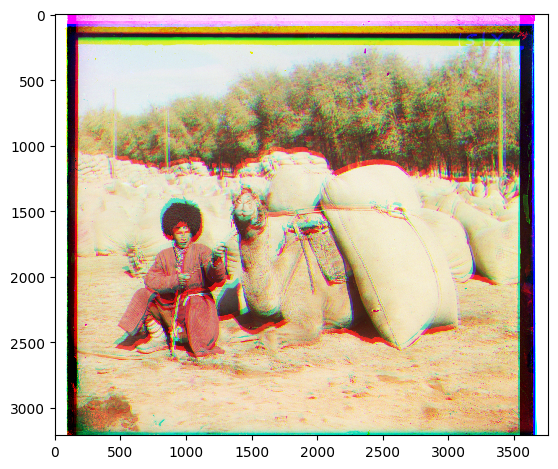

In [86]:


stack_algo = partial(ssd_brute_force_stack)
output_file_prefix = 'ssd'

for imfname in os.listdir('data'):
    # name of the input file
    impath = f'data/{imfname}'
    imtitle = os.path.splitext(imfname)[0]
    # print(imtitle)

    # read in the image
    im = skio.imread(impath)
    r,g,b = get_channels(im)

    # align and stack
    im_out, r_shift, g_shift = stack_algo(r,g,b)

    # save the image
    output_dir = f'output/{output_file_prefix}/'
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    fname = os.path.join(output_dir, f'{imtitle}.jpg')

    skio.imsave(fname, im_out)
    with open(os.path.join(output_dir, f'shifts.txt'), 'a') as f:
        f.write(f'\t{r_shift=}\t{g_shift=}\t{imtitle}\n')

    # display the image
    skio.imshow(im_out)
    skio.show()

In [88]:
output_file_prefix = 'resized_original'

for imfname in os.listdir('data'):
    # name of the input file
    impath = f'data/{imfname}'
    imtitle = os.path.splitext(imfname)[0]
    # print(imtitle)

    # read in the image
    im = skio.imread(impath)

    im_out = sk.transform.rescale(im, 1/4) # scale down to reduce search space

    # save the image
    output_dir = f'output/{output_file_prefix}/'
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    fname = os.path.join(output_dir, f'{imtitle}.jpg')

    skio.imsave(fname, im_out)